# Collect Data
We use a preprocessed version of a famous datasets in heartbeat classification, [the MIT-BIH Arrhythmia Dataset](https://physionet.org/content/mitdb/1.0.0/).
The signals in this dataset correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. We will use the Arrhythmia Dataset used in [this paper](https://arxiv.org/abs/1805.00794) which is the preprocessed arrhythmia dataset consisting of signals that are preprocessed and segmented, with each segment corresponding to a heartbeat in the dataset. This dataset is composed of 109446 samples which are classified into 5 categories.

In [ ]:
!mkdir ECG
%cd ECG

In [ ]:
!gdown --id 1vMLYyzS_zuWxSQEyHtXoTsfqjgoYQmVC
!unzip 29414_37484_bundle_archive.zip

In [ ]:
 from google.colab import drive

drive.mount('/content/drive', force_remount=True)

%cp -r /content/drive/MyDrive/$FOLDERNAME /content/
!unzip /content/$FOLDERNAME/29414_37484_bundle_archive.zip

Mounted at /content/drive
Archive:  /content/new/29414_37484_bundle_archive.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display
import torch.backends.cudnn as cudnn
import random

def set_seed(seed):
    cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# Read The Dataset


In [ ]:
dataframe_train = pd.read_csv("mitbih_train.csv", header=None)
dataframe_test = pd.read_csv("mitbih_test.csv", header=None)
data_train = np.array(dataframe_train.drop(columns=187)).astype('float32')
labels_train = np.array(dataframe_train[187]).astype('int64')
data_test = np.array(dataframe_test.drop(columns=187)).astype('float32')
labels_test = np.array(dataframe_test[187]).astype('int64')

In [ ]:

assert data_train.shape == (87554, 187)
assert labels_train.shape == (87554,)
assert len (labels_train[labels_train == 4]) == 6431
assert data_test.shape == (21892, 187)
assert labels_test.shape == (21892,)

assert data_train.dtype == np.float32
assert labels_train.dtype == np.int64
assert data_test.dtype  == np.float32
assert labels_test.dtype  == np.int64
print ("Test passed")

Test passed


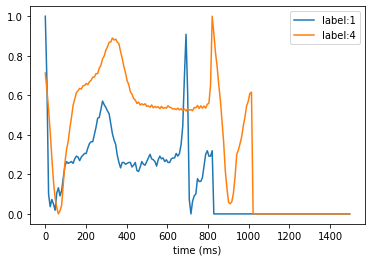

In [ ]:
t = np.linspace (0,(187/125)*1000, 187)
plt.plot (t,data_train[labels_train == 1][0] , label = f"label:{labels_train[labels_train == 1][0]}")
plt.plot (t,data_train[labels_train == 4][0] , label = f"label:{labels_train[labels_train == 4][0]}")
plt.legend()
plt.xlabel("time (ms)")
plt.show()

# Create Custom Dataset

In [ ]:
class HeartbeatDataset(Dataset):

    def __init__(self, data, labels):
        self.labels = labels
        self.train = data

    def __getitem__(self, index):
        return self.train[index], self.labels[index]

    def __len__(self):
        return len(self.train)

batch_size = 64

train_set = HeartbeatDataset(data_train, labels_train)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_set = HeartbeatDataset(data_test, labels_test)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [ ]:
assert len (train_set) == 87554
assert len (test_set) == 21892
(batch_data, batch_label) = next (iter (train_loader))
assert batch_data.shape == (batch_size, 187)
assert batch_label.shape == (batch_size,)
print ("passed")

passed


In [ ]:
num_classes = 5
class_samples_num = [0 for i in range(num_classes)]
for data in train_loader:
    inputs, labels = data
    for i in labels:
        class_samples_num[i] += 1

print(class_samples_num)

[72471, 2223, 5788, 641, 6431]


# Create LSTM Classifier (8 points)
The structure of the network must be as follows:

  (lstm): LSTM(1, 64, batch_first=True)<br>
  (fc1): Linear(in_features=64, out_features=32, bias=True)<br>
  (relu): ReLU()<br>
  (fc2): Linear(in_features=32, out_features=5, bias=True)<br>


In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self):
        super(LSTMClassifier, self).__init__()
        #lstm layer
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc1 = nn.Linear(in_features=64, out_features=32, bias=True)
        self.fc2 = nn.Linear(in_features=32, out_features=5, bias=True)

    def forward(self, x):
        x = x.unsqueeze(-1)
        _ , x = self.lstm(x)
        x = F.relu(self.fc1(x[0][-1]))
        x = self.fc2(x)
        return F.softmax(x)

In [ ]:
(batch_data, batch_label) = next (iter (train_loader))
model = LSTMClassifier().to(device)
output = model (batch_data.to(device)).cpu()
assert output.shape == (batch_size, 5)
print ("passed")

passed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Define loss function and optimizer

In [ ]:
lstm_classifier = LSTMClassifier()
lstm_classifier.to(device)

def get_loss_weights(class_samples_num):
    weight = []
    for x in class_samples_num:
      weight.append(1/x)
    loss_weight = torch.tensor(weight).type(torch.FloatTensor)
    return loss_weight

criterion = nn.CrossEntropyLoss(weight=get_loss_weights(class_samples_num))
criterion.to(device)
optimizer = torch.optim.Adam(lstm_classifier.parameters() , lr=1e-3)

In [ ]:
data , label = next(iter(train_loader))
output = lstm_classifier(data.to(device))

assert output.shape == (batch_size, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Train the classifier


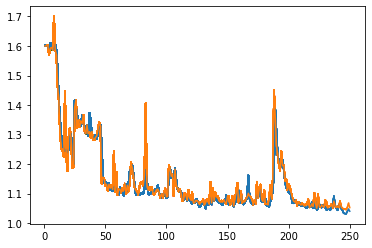

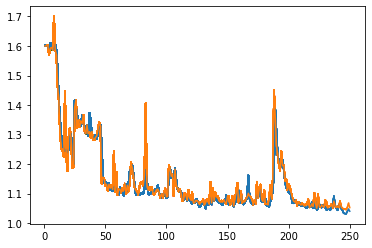

In [ ]:
epoch_num = 250

train_log = []
test_log = []
set_seed(111)
for epoch in range(1, epoch_num+1):

    running_loss = 0
    train_loss = []
    lstm_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    lstm_classifier.eval()
    with torch.no_grad():
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_classifier(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

# Test the classifier


In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    lstm_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lstm_classifier(inputs)
        y_true += torch.eye(num_classes)[labels].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



ROC_AUC Score: 0.9403510564367388
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     18118
           1       0.25      0.70      0.36       556
           2       0.73      0.89      0.80      1448
           3       0.21      0.88      0.34       162
           4       0.92      0.89      0.90      1608

    accuracy                           0.88     21892
   macro avg       0.62      0.85      0.67     21892
weighted avg       0.94      0.88      0.90     21892



# Create Convolutional Classifier (8 points)
The structure of the model is like this:<br>
  (conv1): Conv1d(cin = 1, cout = 64, kernel size = 19)<br>
  (fc1): Linear(in_features=64*187, out_features=32, bias=True)<br>
  (relu): ReLU()<br>
  (fc2): Linear(in_features=32, out_features=5, bias=True)<br>



In [ ]:
class ConvClassifier(nn.Module):

    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv = nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size = 19, padding = 9)
        self.fc1 = nn.Linear(in_features = 64*187, out_features = 32, bias = True)
        self.fc2 = nn.Linear(in_features = 32, out_features = 5, bias = True)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = F.relu(self.fc1(x.reshape(x.shape[0], (x.shape[1] * x.shape[2]))))
        x = self.fc2(x)
        return F.softmax(x)


In [ ]:
conv_classifier = ConvClassifier()
conv_classifier.to(device)

criterion = nn.CrossEntropyLoss(weight = get_loss_weights(class_samples_num))
criterion.to(device)
optimizer = torch.optim.Adam(conv_classifier.parameters())

In [ ]:
data , label = next(iter(train_loader))
output = conv_classifier(data.to(device))

assert output.shape == (batch_size, 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


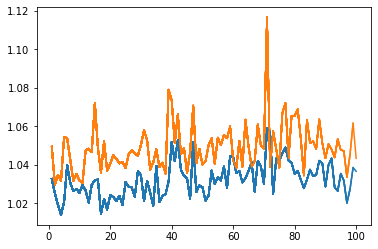

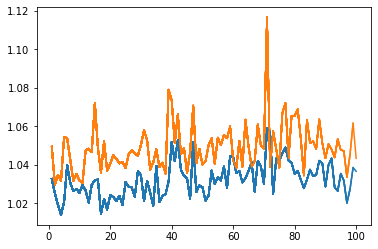

In [ ]:
epoch_num = 100

train_log = []
test_log = []
set_seed(111)
for epoch in range(1, epoch_num+1):

    running_loss = 0
    train_loss = []
    conv_classifier.train()
    for (inputs, labels) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = conv_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_log.append(np.mean(train_loss))

    running_loss = 0
    test_loss = []
    conv_classifier.eval()
    with torch.no_grad():
        for (inputs, labels) in tqdm(test_loader, desc='Test', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = conv_classifier(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
    test_log.append(np.mean(test_loss))
    plt.plot(range(1, epoch+1), train_log, color='C0')
    plt.plot(range(1, epoch+1), test_log, color='C1')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    conv_classifier.eval()
    for (inputs, labels) in tqdm(test_loader, desc='Test'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = conv_classifier(inputs)
        y_true += torch.eye(num_classes)[labels].tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print('ROC_AUC Score:', roc_auc_score(y_true, y_pred))
print(classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



ROC_AUC Score: 0.9188220972594315
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18118
           1       0.53      0.67      0.59       556
           2       0.70      0.91      0.79      1448
           3       0.16      0.85      0.27       162
           4       0.83      0.95      0.88      1608

    accuracy                           0.90     21892
   macro avg       0.64      0.86      0.70     21892
weighted avg       0.94      0.90      0.91     21892



# Comparing The Models (6 points)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print ("Parameters for lstm classifier=" , count_parameters(lstm_classifier))

Parameters for lstm classifier= 19397


In [ ]:
print ("Parameters for conv classifier=" , count_parameters(conv_classifier))

Parameters for conv classifier= 384453
